In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 

import utils.sde_lib
import utils.models
import utils.losses as losses
from utils.datasets import get_dataset
import utils.samplers
from utils.misc import dotdict, batch_matrix_product

In [7]:
opts =  dotdict({
    'dataset': 'spiral',
    'lr' : 3e-4,
    'num_iters' : 1000,
    'batch_size' : 512, 
    
})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = get_dataset(opts)
dim = dataset.dim
model_backward = utils.models.MLP(dim=dim,augmented_sde=True).to(device=device)
model_forward = utils.models.MLP(dim=dim,augmented_sde=True).to(device=device)


itr=500
model_path = f'./exp/momentum/itr_{itr}'

# model_path = f'./checkpoints/cld/itr_{itr}'
model_forward = utils.models.MatrixTimeEmbedding(4,2).to(device=device)
model_backward = torch.load(os.path.join(model_path,f'backward_ema_{itr}.pt'))
# model_forward = torch.load(os.path.join(model_path,f'forward_ema_{itr}.pt'))
# sde = utils.sde_lib.LinearMomentumSchrodingerBridge()
sde = utils.sde_lib.MomentumSchrodingerBridge()
# sde = utils.sde_lib.CLD()
sde.backward_score = model_backward
sde.forward_score = model_forward
sde.forward_score = lambda x,t : 0

In [3]:
t = torch.linspace(0,1,3, device=device).unsqueeze(0)
# print(-sde.D(t))

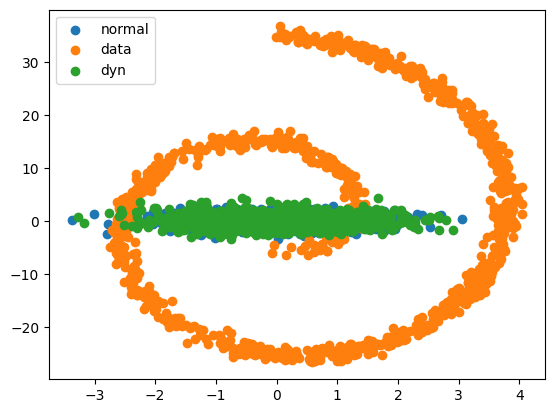

In [8]:
data = dataset.sample(1000).to(device=device)
aug_data = torch.cat((data, torch.zeros_like(data)),dim=-1)

noise, trajectory = sde.sample((1000,4),device,False, in_cond=aug_data)
rand = torch.randn_like(noise)
for i in range(trajectory.shape[1]):
    plt.close()
    plt.scatter(rand[:,0].cpu(),rand[:,1].cpu(),label='normal')
    plt.scatter(aug_data[:,0].cpu(),aug_data[:,1].cpu(),label='data')
    plt.scatter(trajectory[:,i,0].cpu(),trajectory[:,i,1].cpu(),label='dyn')
    plt.legend()
    plt.savefig(f'trajectory/{i}.png')